# Exercise 5 - Thyroid desease prediction using Convolutional Neural Networks


Available at: 
- https://archive.ics.uci.edu/ml/datasets/Thyroid+Disease
- http://networkrepository.com/thyroid-disease-thyroid0387.php
- https://search.r-project.org/CRAN/refmans/MoTBFs/html/thyroid.html

## 1. Importing libraries

In [2]:
import os

import pandas as pd
import io
import requests
import numpy as np
import math
import itertools    
import random

from sklearn import preprocessing
from sklearn import model_selection
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow import keras

print("TF version:", tf.version)

from keras.layers import Dense
from keras.layers import Dropout
from keras.models import Sequential
from keras.optimizers import SGD
from keras.optimizers import Adam

from tensorflow.python.client import device_lib
print("Is GPU backend?\n", device_lib.list_local_devices())

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import EditedNearestNeighbours, CondensedNearestNeighbour

import matplotlib.pyplot as plt
from collections import Counter


from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

2022-06-25 12:10:34.006342: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


TF version: <module 'tensorflow._api.v2.version' from '/home/trdp/anaconda3/envs/ml_env/lib/python3.9/site-packages/tensorflow/_api/v2/version/__init__.py'>
Is GPU backend?
 [name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4045733830364778292
]


2022-06-25 12:10:36.415718: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-25 12:10:36.422844: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-25 12:10:36.422873: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-25 12:10:36.422897: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ideapad320): /proc/driver/nvidia/version does not exist
2022-06-25 12:10:36.422953: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA d

## Downloading Training Dataset

The first step is the download of dataset and transform it into a pandas dataframe

In [3]:
print("Downloading the dataset")
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/thyroid-disease/ann-train.data"
s = requests.get(url).contents=requests.get(url).content
print("Tranform to pandas dataframe")
dataTrain=pd.read_csv(io.StringIO(s.decode('utf-8')),delimiter=' ',header=None)


print("Shape:", dataTrain.shape)
print("Head")
dataTrain.head()

Tranform to pandas dataframe
Shape: (3772, 24)
Head


,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0.73,0,1,0,0,0,0,0,1,0,...,0,0,0.00060,0.015,0.120,0.082,0.146,3,NaN,NaN
1,0.24,0,0,0,0,0,0,0,0,0,...,0,0,0.00025,0.030,0.143,0.133,0.108,3,NaN,NaN
2,0.47,0,0,0,0,0,0,0,0,0,...,0,0,0.00190,0.024,0.102,0.131,0.078,3,NaN,NaN
3,0.64,1,0,0,0,0,0,0,0,0,...,0,0,0.00090,0.017,0.077,0.090,0.085,3,NaN,NaN
4,0.23,0,0,0,0,0,0,0,0,0,...,0,0,0.00025,0.026,0.139,0.090,0.153,3,NaN,NaN


In [4]:
# Removing NaN columns
del dataTrain[22]
del dataTrain[23]

In [5]:
# Visualizing the data
dataTrain.head()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,0.73,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0.00060,0.015,0.120,0.082,0.146,3
1,0.24,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.00025,0.030,0.143,0.133,0.108,3
2,0.47,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.00190,0.024,0.102,0.131,0.078,3
3,0.64,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0.00090,0.017,0.077,0.090,0.085,3
4,0.23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.00025,0.026,0.139,0.090,0.153,3


In [6]:
#Predictor data
inputTrain = dataTrain.drop([21], axis=1)
inputTrain.head()        

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.73,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0.00060,0.015,0.120,0.082,0.146
1,0.24,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.00025,0.030,0.143,0.133,0.108
2,0.47,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.00190,0.024,0.102,0.131,0.078
3,0.64,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.00090,0.017,0.077,0.090,0.085
4,0.23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.00025,0.026,0.139,0.090,0.153


In [7]:
# Target data
outputTrain = dataTrain[21] - 1

print("Labels", Counter(outputTrain))

Labels Counter({2: 3488, 1: 191, 0: 93})


In [8]:
#
# Downloading test data
#
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/thyroid-disease/ann-test.data"
s = requests.get(url).contents=requests.get(url).content
dataTest=pd.read_csv(io.StringIO(s.decode('utf-8')),delimiter=' ',header=None)

dataTest.head()

print(dataTest.shape)
dataTest.head()

(3428, 24)


,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0.29,0,0,0,0,0,0,0,0,0,...,0,0,0.0061,0.028,0.111,0.131,0.085,2,NaN,NaN
1,0.32,0,0,0,0,0,0,0,0,0,...,0,0,0.0013,0.019,0.084,0.078,0.107,3,NaN,NaN
2,0.35,0,0,0,0,0,0,0,0,0,...,0,0,0.0000,0.031,0.239,0.100,0.239,3,NaN,NaN
3,0.21,0,0,0,0,0,0,0,0,0,...,0,0,0.0010,0.018,0.087,0.088,0.099,3,NaN,NaN
4,0.22,0,0,0,0,1,0,0,0,0,...,0,0,0.0004,0.022,0.134,0.135,0.099,3,NaN,NaN


In [9]:
del dataTest[22]
del dataTest[23]

In [10]:
inputTest = dataTest.drop([21], axis=1)
outputTest = dataTest[21] - 1

## Feature Selection

In this section, we add a feature selection step, using $\chi^2$ test, which was not required to the assignment.

We try some values of features to be selected ($k$) and check the $k$ that produces the highest macro recall in the validation set.

One can see that with 13 features, the recall metric is significantly better than using almost all of the features.

k = 10, selected_features: ['x1' 'x2' 'x5' 'x6' 'x7' 'x9' 'x15' 'x16' 'x18' 'x20']


/home/trdp/anaconda3/envs/ml_env/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[[ 18   0   1]
 [  0  30   8]
 [  2   2 694]]
k = 13, selected_features: ['x1' 'x2' 'x4' 'x5' 'x6' 'x7' 'x9' 'x10' 'x12' 'x15' 'x16' 'x18' 'x20']


/home/trdp/anaconda3/envs/ml_env/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[[ 19   0   0]
 [  0  34   4]
 [  2   1 695]]
k = 15, selected_features: ['x1' 'x2' 'x3' 'x4' 'x5' 'x6' 'x7' 'x8' 'x9' 'x10' 'x12' 'x15' 'x16'
 'x18' 'x20']


/home/trdp/anaconda3/envs/ml_env/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[[ 18   1   0]
 [  2  35   1]
 [  2  11 685]]
k = 20, selected_features: ['x1' 'x2' 'x3' 'x4' 'x5' 'x6' 'x7' 'x8' 'x9' 'x10' 'x11' 'x12' 'x13'
 'x14' 'x15' 'x16' 'x17' 'x18' 'x19' 'x20']
[[ 18   1   0]
 [  0  33   5]
 [  1   3 694]]


/home/trdp/anaconda3/envs/ml_env/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


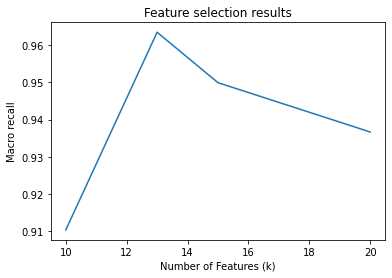

In [42]:
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.metrics import classification_report,recall_score
from sklearn.model_selection import train_test_split

recalls = []
ks = [10, 13, 15, 20]

x_train, x_val, y_train, y_val = train_test_split(inputTrain, outputTrain, test_size=0.2, shuffle=True, stratify=outputTrain)
y_train_one_hot = keras.utils.to_categorical(y_train)
y_val_one_hot = keras.utils.to_categorical(y_val)

for k in ks:
   
    # configure to select all features
    fs = SelectKBest(score_func=chi2, k=k)

    # learn relationship from training data
    fs.fit(x_train, y_train)
    # transform train input data
    X_train_fs = fs.transform(x_train)
    # transform test input data
    X_val_fs = fs.transform(x_val)

    print("k = %d, selected_features: %s"% (k, str(fs.get_feature_names_out())))
    model = KerasClassifier(build_fn=create_model, input_shape=X_train_fs.shape[1], epochs=200, verbose=0, hidden_layer_sizes=(256,256,256,))
    model.fit(X_train_fs,y_train_one_hot)

    y_pred = model.predict(X_val_fs)

    recall_value = recall_score(y_val,y_pred, average="macro")
    print(confusion_matrix(y_val, y_pred))
    recalls.append(recall_value)

plt.title("Feature selection results")
plt.xlabel("Number of Features (k)")
plt.ylabel("Macro recall")
plt.plot(ks, recalls)
plt.show()


## Scaling features

In [13]:
scaler = preprocessing.MinMaxScaler()
# fit using the train set
scaler.fit(inputTrain)
# transform the test test
xtrainN = scaler.transform(inputTrain)
xtestN = scaler.transform(inputTest) 

In [14]:
outputTrain_one_hot = keras.utils.to_categorical(outputTrain)

In [15]:
#
# Calculating class weights
#
class_weights = compute_class_weight(class_weight='balanced', classes = np.unique(outputTrain), y=outputTrain)
print("Labels:", np.unique(outputTrain))
print("Class weights:", class_weights)
d_class_weights = dict(enumerate(class_weights))

Labels: [0 1 2]
Class weights: [13.51971326  6.58289703  0.36047401]


In [16]:
X_train, X_validation, y_train, y_validation = model_selection.train_test_split(
    xtrainN, 
    outputTrain_one_hot, 
    test_size = 0.2, 
    random_state = 1, 
    stratify=outputTrain
)  

print("Train shape", X_train.shape, Counter(np.argmax(y_train, axis=1)))
print("Validation shape", X_validation.shape, Counter(np.argmax(y_validation, axis=1)))

Train shape (3017, 21) Counter({2: 2790, 1: 153, 0: 74})
Validation shape (755, 21) Counter({2: 698, 1: 38, 0: 19})


In [17]:
tf.keras.backend.clear_session()
model = Sequential(
    [
        Dense(256, activation="relu", input_shape=(X_train.shape[-1],)
        ),
        Dropout(0.3),
        #Dense(256, activation="relu"),
        #Dropout(0.3),
        Dense(256, activation="relu"),
        Dropout(0.3),
        Dense(3, activation="sigmoid"),
    ]
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               5632      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 771       
Total params: 72,195
Trainable params: 72,195
Non-trainable params: 0
_________________________________________________________________


2022-06-25 12:11:21.957908: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-06-25 12:11:21.958152: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set


2022-06-25 10:26:12.212020: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-06-25 10:26:12.228645: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2899885000 Hz


Epoch 1/4096
24/24 - 2s - loss: 0.6420 - fn: 2767.0000 - fp: 428.0000 - tn: 5606.0000 - tp: 250.0000 - precision: 0.3687 - recall: 0.0829 - val_loss: 0.5748 - val_fn: 755.0000 - val_fp: 0.0000e+00 - val_tn: 1510.0000 - val_tp: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/4096
24/24 - 0s - loss: 0.5834 - fn: 2877.0000 - fp: 8.0000 - tn: 6026.0000 - tp: 140.0000 - precision: 0.9459 - recall: 0.0464 - val_loss: 0.5189 - val_fn: 547.0000 - val_fp: 15.0000 - val_tn: 1495.0000 - val_tp: 208.0000 - val_precision: 0.9327 - val_recall: 0.2755
Epoch 3/4096
24/24 - 0s - loss: 0.5163 - fn: 1739.0000 - fp: 101.0000 - tn: 5933.0000 - tp: 1278.0000 - precision: 0.9268 - recall: 0.4236 - val_loss: 0.4727 - val_fn: 419.0000 - val_fp: 126.0000 - val_tn: 1384.0000 - val_tp: 336.0000 - val_precision: 0.7273 - val_recall: 0.4450
Epoch 4/4096
24/24 - 0s - loss: 0.4372 - fn: 1416.0000 - fp: 608.0000 - tn: 5426.0000 - tp: 1601.0000 - precision: 0.7248 - recall: 0.5307 - val_loss: 0.

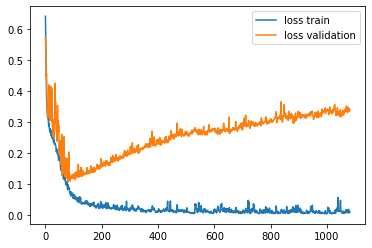

In [ ]:
metrics = [
    keras.metrics.FalseNegatives(name="fn"),
    keras.metrics.FalsePositives(name="fp"),
    keras.metrics.TrueNegatives(name="tn"),
    keras.metrics.TruePositives(name="tp"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall")
]

model.compile(
    optimizer=Adam(1e-3), loss="binary_crossentropy", metrics=metrics
)

callbacks = [
    keras.callbacks.ModelCheckpoint("checkpoints/thyroid_model_at_epoch_{epoch}.h5"),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=1000, restore_best_weights=True)
]

history = model.fit(
    X_train,
    y_train,
    batch_size=128,
    epochs=4096,
    verbose=2,
    callbacks=callbacks,
    validation_data=(X_validation, y_validation),
    class_weight=d_class_weights,
)

plt.plot(history.history['loss'], label='loss train')
plt.plot(history.history['val_loss'], label='loss validation')
plt.legend()


## Method to create model based on hyperparameters


In [18]:


def create_model(
        lr=1e-3, 
        patience=1000, 
        hidden_layer_sizes=(256,256,256),
        dropouts=(None,0.3,0.3),
        opt="adam",
        hidden_activations = ("relu", "relu", "relu"),
        input_shape=X_train.shape[1]
    ):
    tf.keras.backend.clear_session()

  

    # Building model
    layers = []
    for hidden_layer_size, dropout, hidden_act in zip(hidden_layer_sizes, dropouts, hidden_activations):
        dense = None
        if len(layers)==0:
            dense=Dense(hidden_layer_size, activation = hidden_act, input_shape=(input_shape,))
        else:
            dense = Dense(hidden_layer_size, activation = hidden_act)

        layers.append(
            dense
        )
        
        if dropout is not None:
            layers.append(Dropout(dropout))
        
    # Output
    layers.append(Dense(3, activation="softmax"))
    model = Sequential(
       layers
    )

    metrics = [
        keras.metrics.FalseNegatives(name="fn"),
        keras.metrics.FalsePositives(name="fp"),
        keras.metrics.TrueNegatives(name="tn"),
        keras.metrics.TruePositives(name="tp"),
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall"),
        keras.metrics.Accuracy(name="accuracy")
    ]

    optimizers = {
        "adam":Adam(lr),
        "sgd":SGD(lr),
    }

    model.compile(
        optimizer=optimizers[opt],  loss="binary_crossentropy", metrics=metrics
    )

    callbacks = [
        keras.callbacks.ModelCheckpoint("checkpoints/thyroid_model_at_epoch_{epoch}.h5"),
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=patience, restore_best_weights=True)
    ]   

    return model

model = create_model()
model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               5632      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 771       
Total params: 137,987
Trainable params: 137,987
Non-trainable params: 0
__________________________________________________

## Running some Tests


In [ ]:
### Learning Rate
lrs = [1e-4, 1e-3 ,1e-2, 1e-1, 1]

### Batch Size
batch_sizes =  [32,64,128,256]

### Optimizer
opts = ["adam", "sgd"]

### Number of layers
layers = [(256,), (256, 256,), (256, 256, 256,)]

### Number of neurons in hidden layers
neurons = [(i, i, i) for i in [64,128,256,512]]


In [ ]:
def evaluate(y_true, y_pred, label):

    print('Confusion Matrix\n')
    print(conf)

    #importing accuracy_score, precision_score, recall_score, f1_score
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_true, y_pred)))

    print('Micro Precision: {:.2f}'.format(precision_score(y_true, y_pred, average='micro')))
    print('Micro Recall: {:.2f}'.format(recall_score(y_true, y_pred, average='micro')))
    print('Micro F1-score: {:.2f}\n'.format(f1_score(y_true, y_pred, average='micro')))

    print('Macro Precision: {:.2f}'.format(precision_score(y_true, TrainPy_predredictions, average='macro')))
    print('Macro Recall: {:.2f}'.format(recall_score(y_true, y_pred, average='macro')))
    print('Macro F1-score: {:.2f}\n'.format(f1_score(y_true, y_pred, average='macro')))

    print('Weighted Precision: {:.2f}'.format(precision_score(y_true, y_pred, average='weighted')))
    print('Weighted Recall: {:.2f}'.format(recall_score(y_true, y_pred, average='weighted')))
    print('Weighted F1-score: {:.2f}'.format(f1_score(y_true, y_pred, average='weighted')))

    from sklearn.metrics import classification_report
    print('\nClassification Report\n')
    print(classification_report(y_true, y_pred, target_names=['Class 1', 'Class 2', 'Class 3']))

## Testing learning rates

In [ ]:
recalls = []
for lr in lrs:
    print("="*100)
    model =KerasClassifier(create_model, lr=lr, verbose=0)

    model.fit(x_train, y_train)

    y_pred = model.predict(x_val)
    evaluate(y_val, y_pred, "Validation")
    recalls.append(recall_score(y_val, y_pred, average="macro"))

    

Confusion Matrix

[[  68    4    1]
 [  16   83   78]
 [  61   69 3048]]

Accuracy: 0.92

Micro Precision: 0.92
Micro Recall: 0.92
Micro F1-score: 0.92



/home/trdp/anaconda3/envs/ml_env/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


NameError: name 'TrainPy_predredictions' is not defined

In [ ]:
TrainPredictions = model.predict(inputTrain)
TrainPredictions = np.argmax(TrainPredictions, axis=1)

Text(0.5, 15.0, 'Predicted label')

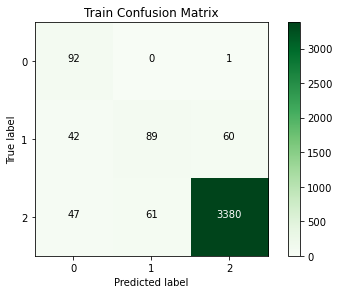

In [ ]:
conf = confusion_matrix(outputTrain, TrainPredictions)

classes = [0, 1, 2]
# plot confusion matrix
plt.imshow(conf, interpolation='nearest', cmap=plt.cm.Greens)
plt.title("Train Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = conf.max() / 2.
for i, j in itertools.product(range(conf.shape[0]), range(conf.shape[1])):
    plt.text(j, i, format(conf[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [ ]:
print('Confusion Matrix\n')
print(conf)

#importing accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(outputTrain, TrainPredictions)))

print('Micro Precision: {:.2f}'.format(precision_score(outputTrain, TrainPredictions, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(outputTrain, TrainPredictions, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(outputTrain, TrainPredictions, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(outputTrain, TrainPredictions, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(outputTrain, TrainPredictions, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(outputTrain, TrainPredictions, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(outputTrain, TrainPredictions, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(outputTrain, TrainPredictions, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(outputTrain, TrainPredictions, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(outputTrain, TrainPredictions, target_names=['Class 1', 'Class 2', 'Class 3']))

Confusion Matrix

[[  92    0    1]
 [  42   89   60]
 [  47   61 3380]]

Accuracy: 0.94

Micro Precision: 0.94
Micro Recall: 0.94
Micro F1-score: 0.94

Macro Precision: 0.69
Macro Recall: 0.81
Macro F1-score: 0.72

Weighted Precision: 0.95
Weighted Recall: 0.94
Weighted F1-score: 0.95

Classification Report

              precision    recall  f1-score   support

     Class 1       0.51      0.99      0.67        93
     Class 2       0.59      0.47      0.52       191
     Class 3       0.98      0.97      0.98      3488

    accuracy                           0.94      3772
   macro avg       0.69      0.81      0.72      3772
weighted avg       0.95      0.94      0.95      3772



In [ ]:
TestPredictions = model.predict(inputTest)
TestPredictions = np.argmax(TestPredictions, axis=1)

Text(0.5, 15.0, 'Predicted label')

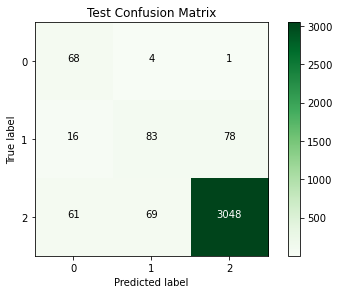

In [ ]:
conf = confusion_matrix(outputTest, TestPredictions)

classes = [0, 1, 2]
# plot confusion matrix
plt.imshow(conf, interpolation='nearest', cmap=plt.cm.Greens)
plt.title("Test Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = conf.max() / 2.
for i, j in itertools.product(range(conf.shape[0]), range(conf.shape[1])):
    plt.text(j, i, format(conf[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [ ]:
print('Confusion Matrix\n')
print(conf)

print('\nAccuracy: {:.2f}\n'.format(accuracy_score(outputTest, TestPredictions)))

print('Micro Precision: {:.2f}'.format(precision_score(outputTest, TestPredictions, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(outputTest, TestPredictions, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(outputTest, TestPredictions, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(outputTest, TestPredictions, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(outputTest, TestPredictions, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(outputTest, TestPredictions, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(outputTest, TestPredictions, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(outputTest, TestPredictions, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(outputTest, TestPredictions, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(outputTest, TestPredictions, target_names=['Class 1', 'Class 2', 'Class 3']))

Confusion Matrix

[[  68    4    1]
 [  16   83   78]
 [  61   69 3048]]

Accuracy: 0.93

Micro Precision: 0.93
Micro Recall: 0.93
Micro F1-score: 0.93

Macro Precision: 0.66
Macro Recall: 0.79
Macro F1-score: 0.70

Weighted Precision: 0.94
Weighted Recall: 0.93
Weighted F1-score: 0.94

Classification Report

              precision    recall  f1-score   support

     Class 1       0.47      0.93      0.62        73
     Class 2       0.53      0.47      0.50       177
     Class 3       0.97      0.96      0.97      3178

    accuracy                           0.93      3428
   macro avg       0.66      0.79      0.70      3428
weighted avg       0.94      0.93      0.94      3428

